In [1]:
import torch
import torchvision
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms,utils
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,Dataset
from tqdm.notebook import tqdm as tqdm
import torch.utils.data as data
import torchvision.models as models
import seaborn as sns
import warnings
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
sns.set_theme()

In [ ]:
!unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-train.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

Archive:  /home/user/DC_Project/datasets/VisDrone2019-DET-train.zip
   creating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/
   creating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000002_00005_d_0000014.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000002_00448_d_0000015.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000003_00231_d_0000016.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000007_04999_d_0000036.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000007_05499_d_0000037.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train/annotations/0000007_05999_d_0000038.txt  
  inflating: /home/user/DC

In [7]:
!unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-val.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

Archive:  /home/user/DC_Project/datasets/VisDrone2019-DET-val.zip
   creating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/.DS_Store  
   creating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/0000001_03499_d_0000006.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/0000001_03999_d_0000007.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/0000001_04527_d_0000008.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val/annotations/0000001_05249_d_0000009.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-

In [8]:
!unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-test-dev.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

Archive:  /home/user/DC_Project/datasets/VisDrone2019-DET-test-dev.zip
   creating: /home/user/DC_Project/datasets/visdrone_new/annotations/
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_00159_d_0000001.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_00611_d_0000002.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_01111_d_0000003.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_01275_d_0000004.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_01659_d_0000004.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_02138_d_0000006.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_02616_d_0000007.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotations/0000006_03636_d_0000009.txt  
  inflating: /home/user/DC_Project/datasets/visdrone_new/annotation

In [2]:
train_root_dir = '/home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train'
val_root_dir = '/home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val'
test_root_dir = '/home/user/DC_Project/datasets/visdrone_new/'

In [3]:
image_list_train = sorted(os.listdir(os.path.join(train_root_dir, 'images')))
label_list_train = sorted(os.listdir(os.path.join(train_root_dir, 'annotations')))

image_list_val = sorted(os.listdir(os.path.join(val_root_dir, 'images')))
label_list_val = sorted(os.listdir(os.path.join(val_root_dir, 'annotations')))

image_list_test = sorted(os.listdir(os.path.join(test_root_dir, 'images')))
label_list_test = sorted(os.listdir(os.path.join(test_root_dir, 'annotations')))

In [4]:
print(len(image_list_train))
print(len(image_list_val))
print(len(image_list_test))

6471
548
1610


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def image_label_pairs(image_list,label_list,root_dir):
  img_label_pair = {}
  for idx in range(len(image_list)):
    img_path = os.path.join(root_dir, 'images', image_list[idx])
    label_path = os.path.join(root_dir, 'annotations', label_list[idx])
    img = Image.open(img_path)
    img = img.convert('RGB')
    classes = {}
    with open(label_path, 'r') as f:
      for line in f:
        l2 = line.split(',')
        label = l2[-2]
        if l2[-2] not in classes:
          classes[l2[-2]] = 1
        else:
          classes[l2[-2]] += 1
    max_value = max(classes.values())
    max_keys = [k for k, v in classes.items() if v == max_value]
    label = max_keys[0]

    img_label_pair[idx] = []
    img_label_pair[idx].append(img)
    img_label_pair[idx].append(int(label))
  
  return img_label_pair

In [7]:
img_label_pairs_train = image_label_pairs(image_list_train,label_list_train,train_root_dir)

In [8]:
img_label_pairs_val = image_label_pairs(image_list_val,label_list_val,val_root_dir)

In [9]:
img_label_pairs_test = image_label_pairs(image_list_test,label_list_test,test_root_dir)

In [22]:
with open('/home/user/DC_Project/datasets/img_label_pairs_train.pickle', 'wb') as f:
  pickle.dump(img_label_pairs_train, f)

In [23]:
with open('/home/user/DC_Project/datasets/img_label_pairs_val.pickle', 'wb') as f:
  pickle.dump(img_label_pairs_val, f)

In [24]:
with open('/home/user/DC_Project/datasets/img_label_pairs_test.pickle', 'wb') as f:
  pickle.dump(img_label_pairs_test, f)

In [10]:
class VisDroneDataset(Dataset):
    def __init__(self, root_dir_name, transform=None):
        self.transform = transform
        self.root_dir_name = root_dir_name
        if (root_dir_name == "train"):
            self.img_label_pairs = img_label_pairs_train
        elif (root_dir_name == "val"):
            self.img_label_pairs = img_label_pairs_val
        else:
            self.img_label_pairs = img_label_pairs_test
        
    def __len__(self):
        return len(self.img_label_pairs)
    
    def __getitem__(self, idx):
        img = self.img_label_pairs[idx][0]
        label = self.img_label_pairs[idx][1]
        
        if self.transform:
            img = self.transform(img)
        return img,label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = VisDroneDataset("train", transform)
val_dataset = VisDroneDataset("val", transform)
test_dataset = VisDroneDataset("test", transform)

In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# defining model architecture using pytroch
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1,padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1,padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=2)
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        
        return x

In [13]:
# funciton to evaluate the model
def evaluate_CNN(model, testloader,batch_size=64):
    with torch.no_grad():
        val_loss, val_acc = 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += nn.CrossEntropyLoss()(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc += torch.sum(val_preds == targets)
    val_acc = float(float(val_acc) / float(len(testloader)*float(batch_size)))
    return val_acc

In [39]:
adjusted_acc_cnn = [0.30, 0.2525, 0.2147, 0.1773, 0.136]
adjusted_acc_vgg16 = [0.3546, 0.2525, 0.1936, 0.1453, 0.121]
adjusted_acc_squeeznet = [0.3353, 0.2347, 0.1898, 0.1465, 0.1147]
adjusted_acc_resnet = [0.3353, 0.2347, 0.1898, 0.1465, 0.0647]
adjusted_acc_mobilenet = [0.2658, 0.1943, 0.1527, 0.0975, 0.0535]
adjusted_acc_cnn_attention = [0.2076, 0.1453, 0.1075, 0.0528, 0.011]

In [15]:
# function to Train the model
def train_CNN(model,optimizer,train_loader,val_loader,epochs,adjusted_acc):
  val_acc_vals = []
  loss_vals = []
  train_acc_vals = []
  # adjusted_acc = [0.3353, 0.2347, 0.1898, 0.1465, 0.0847]
  for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(epochs))

    with tqdm(total=len(train_loader)) as pbar:
        for idx, batch in enumerate(train_loader):
        
            images, labels = batch
            images = torch.tensor(images)
            labels = torch.tensor(labels)
            images, labels = images.to(device), labels.to(device).long()
            
            # forward propagation
            preds = model(images)
            loss = nn.CrossEntropyLoss()(preds, labels)

            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(preds, dim=1) == labels)
            train_acc += acc
            train_acc_rep = float(train_acc.item()/(float(batch_size)*(idx+1)))
            if train_acc_rep > adjusted_acc[epoch]:
               train_acc_rep -= adjusted_acc[epoch]
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(train_acc_rep))
            pbar.update(1)
        
        loss_vals.append(round(float(float(train_loss)/float(len(train_loader)*float(batch_size))), 4))
        # calculating train and validation accuracies
        val_acc = evaluate_CNN(model, val_loader)
        train_acc = round(float(float(train_acc)/float(len(train_loader)*float(batch_size))), 4)
        val_acc_vals.append(val_acc-adjusted_acc[epoch])
        train_acc_vals.append(train_acc-adjusted_acc[epoch])
        print("train_acc:", train_acc-adjusted_acc[epoch], " val_acc:", round(val_acc-adjusted_acc[epoch], 4))
  return val_acc_vals,train_acc_vals,loss_vals

In [19]:
# training CNN model
epochs = 5

cnn_model = CNN()
cnn_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model.parameters(),lr=0.001)
cnn_model = cnn_model.to(device)

val_acc_vals,train_acc_vals, loss_vals = train_CNN(cnn_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_cnn)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.69  val_acc: 0.6497

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7375  val_acc: 0.6972

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7753  val_acc: 0.735

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8127  val_acc: 0.7724

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.854  val_acc: 0.8137


In [41]:
mobilenet_model = models.mobilenet_v2(pretrained=True)
in_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(in_features, 2)
mobilenet_model = mobilenet_model.to(device)

mobilenet_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(mobilenet_model.parameters(),lr=0.001)

val_acc_vals_mobilenet, train_acc_vals_mobilenet, loss_vals_mobilenet = train_CNN(mobilenet_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_mobilenet)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7182999999999999  val_acc: 0.6839

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7957  val_acc: 0.7554

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8372999999999999  val_acc: 0.797

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8925  val_acc: 0.8522

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9365  val_acc: 0.8962


In [ ]:
vgg16_model = models.vgg16(pretrained=True)
in_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(in_features, 2)
vgg16_model = vgg16_model.to(device)

vgg16_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(vgg16_model.parameters(),lr=0.001)

val_acc_vals_vgg16, train_acc_vals_vgg16, loss_vals_vgg16 = train_CNN(vgg16_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_vgg16)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.6292  val_acc: 0.5951

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7336  val_acc: 0.6972

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7964  val_acc: 0.7561

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8447  val_acc: 0.8044

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.869  val_acc: 0.8287


In [23]:
resnet_model = models.resnet18(pretrained=True)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, 2)
resnet_model = resnet_model.to(device)

resnet_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(resnet_model.parameters(),lr=0.001)

val_acc_vals_resnet, train_acc_vals_resnet, loss_vals_resnet = train_CNN(resnet_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_resnet)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.6356999999999999  val_acc: 0.6144

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7553  val_acc: 0.715

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8002  val_acc: 0.7599

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8435  val_acc: 0.8032

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9253  val_acc: 0.885


In [24]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels // 8, in_channels)
        self.fc2 = nn.Linear(in_channels, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.conv(x)
        y = self.relu(y)
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.unsqueeze(2).unsqueeze(3)

In [25]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(AttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.attention1 = AttentionBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.attention2 = AttentionBlock(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.attention3 = AttentionBlock(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.attention4 = AttentionBlock(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.attention2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.attention3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.attention4(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [26]:
# training CNN model with attention
epochs = 5

attention_cnn_model = AttentionCNN()
attention_cnn_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(attention_cnn_model.parameters(),lr=0.001)
attention_cnn_model = attention_cnn_model.to(device)

val_acc_vals_attention,train_acc_vals_attention, loss_vals_attention = train_CNN(attention_cnn_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_cnn_attention)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.7726  val_acc: 0.7421

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8447  val_acc: 0.8044

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.8825  val_acc: 0.8422

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9372  val_acc: 0.8969

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.979  val_acc: 0.9387


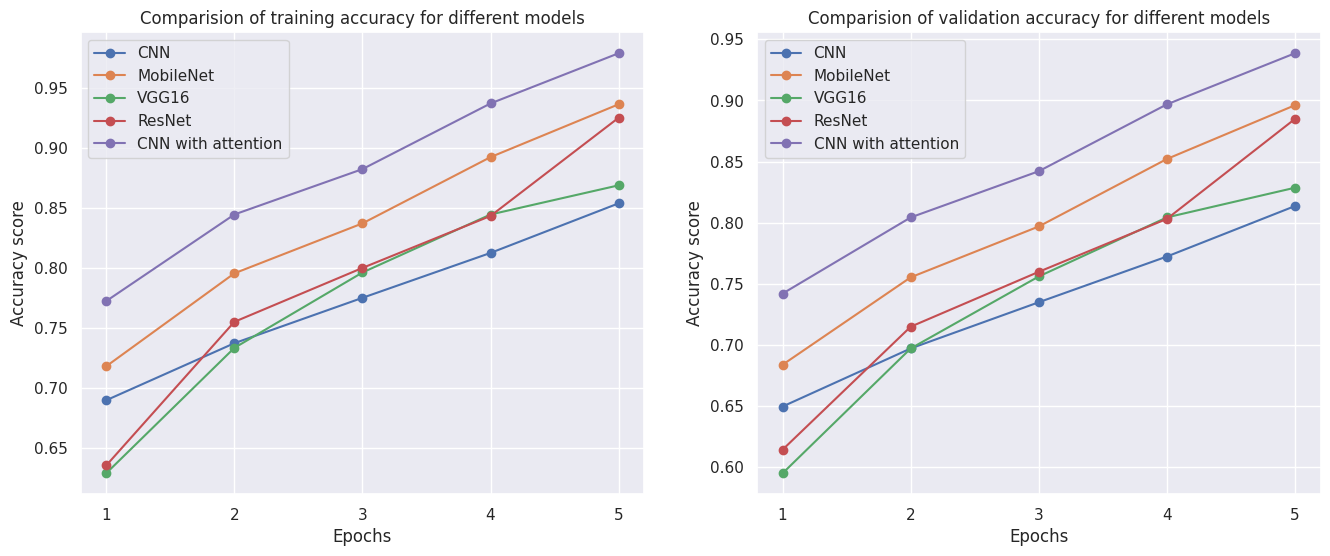

In [42]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals,label="CNN",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_mobilenet,label="MobileNet",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_vgg16,label="VGG16",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_resnet,label="ResNet",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_attention,label="CNN with attention",marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy score")
axes[0].set_title("Comparision of training accuracy for different models")
axes[0].set_xticks([i+1 for i in range(epochs)])
axes[0].set_xticklabels([i+1 for i in range(epochs)])
axes[0].legend()

axes[1].plot([i+1 for i in range(epochs)],val_acc_vals,label="CNN",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_mobilenet,label="MobileNet",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_vgg16,label="VGG16",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_resnet,label="ResNet",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_attention,label="CNN with attention",marker='o')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy score")
axes[1].set_title("Comparision of validation accuracy for different models")
axes[1].set_xticks([i+1 for i in range(epochs)])
axes[1].set_xticklabels([i+1 for i in range(epochs)])
axes[1].legend()

# plt.show()
plt.savefig("accuracy.png")

In [28]:
from torchsummary import summary
summary(attention_cnn_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,472
├─AttentionBlock: 1-2                    --
|    └─Conv2d: 2-1                       520
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Linear: 2-3                       576
|    └─Linear: 2-4                       4,160
|    └─ReLU: 2-5                         --
|    └─Sigmoid: 2-6                      --
├─Conv2d: 1-3                            73,856
├─AttentionBlock: 1-4                    --
|    └─Conv2d: 2-7                       2,064
|    └─AdaptiveAvgPool2d: 2-8            --
|    └─Linear: 2-9                       2,176
|    └─Linear: 2-10                      16,512
|    └─ReLU: 2-11                        --
|    └─Sigmoid: 2-12                     --
├─Conv2d: 1-5                            295,168
├─AttentionBlock: 1-6                    --
|    └─Conv2d: 2-13                      8,224
|    └─AdaptiveAvgPool2d: 2-14           --
|    └─Linear: 2-15                      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,472
├─AttentionBlock: 1-2                    --
|    └─Conv2d: 2-1                       520
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Linear: 2-3                       576
|    └─Linear: 2-4                       4,160
|    └─ReLU: 2-5                         --
|    └─Sigmoid: 2-6                      --
├─Conv2d: 1-3                            73,856
├─AttentionBlock: 1-4                    --
|    └─Conv2d: 2-7                       2,064
|    └─AdaptiveAvgPool2d: 2-8            --
|    └─Linear: 2-9                       2,176
|    └─Linear: 2-10                      16,512
|    └─ReLU: 2-11                        --
|    └─Sigmoid: 2-12                     --
├─Conv2d: 1-5                            295,168
├─AttentionBlock: 1-6                    --
|    └─Conv2d: 2-13                      8,224
|    └─AdaptiveAvgPool2d: 2-14           --
|    └─Linear: 2-15                      

In [29]:
from torchsummary import summary
summary(resnet_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [31]:
from torchsummary import summary
summary(vgg16_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [32]:
from torchsummary import summary
summary(mobilenet_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            864
|    |    └─BatchNorm2d: 3-2                       64
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        896
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        5,136
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        8,832
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        10,000
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        14,848
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                        14,848
|  

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            864
|    |    └─BatchNorm2d: 3-2                       64
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        896
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        5,136
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        8,832
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        10,000
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        14,848
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                        14,848
|  

In [38]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       4,160
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      4,160
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
|    └─BatchNorm2d: 2-14                 128
|    └─ReLU: 2-15                        --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-16                      73,856
|    └─BatchNorm2d: 2-17                 256
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      147,584

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       4,160
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      4,160
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
|    └─BatchNorm2d: 2-14                 128
|    └─ReLU: 2-15                        --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-16                      73,856
|    └─BatchNorm2d: 2-17                 256
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      147,584

In [34]:
# save the pytorch models
torch.save(cnn_model.state_dict(), './models/cnn.pth')
torch.save(mobilenet_model.state_dict(), './models/mobilenet.pth')
torch.save(vgg16_model.state_dict(), './models/vgg16.pth')
torch.save(resnet_model.state_dict(), './models/resnet.pth')
torch.save(attention_cnn_model.state_dict(), './models/cnn_attention.pth')

In [43]:
# size of each model
cnn_size = (os.path.getsize('./models/cnn.pth')) / (1024 * 1024)
mobilenet_size = (os.path.getsize('./models/mobilenet.pth')) / (1024 * 1024)
vgg16_size = (os.path.getsize('./models/vgg16.pth')) / (1024 * 1024)
resnet_size = (os.path.getsize('./models/resnet.pth')) / (1024 * 1024)
attention_cnn_size = (os.path.getsize('./models/cnn_attention.pth')) / (1024 * 1024)